## Imports and Reading Datasets

In [7]:
!pip install --user uszipcode
from uszipcode import SearchEngine
import pandas as pd
import numpy as np
import random

search = SearchEngine(simple_zipcode=True)
df = pd.read_csv('/datasets/iowaliquor.csv')[['Date', 'Store Name', 'Zip Code', 'Sale (Dollars)', 'County']]
election_df = pd.read_csv('usa-2016-presidential-election-by-county.csv', sep=';')
election_df = election_df[election_df['State'] == 'Iowa']

## Fill Missing Zip Codes

In [2]:
unqs = df[df["Zip Code"].isna()]["Store Name"].unique() # get unique store names
cities = [store.split("/")[-1].strip().lower() for store in unqs if "/" in store] # extract city name
if "mlk" in cities:
    cities.remove("mlk")
subset = df[df["Store Name"].str.contains("/") & (df["Zip Code"].isna())] 
city_dict = {}
for city in set(cities): # get zip code from rows with cities in store name
    city_dict[city] = search.by_city_and_state(city, "iowa")[0].zipcode
city_dict["mlk"] = '50310'
df.loc[subset.index, 'Zip Code'] = subset["Store Name"].str.split("/").str[-1].str.strip().str.lower().map(city_dict) 

## Aggregate and Get Zip Code Statistics

In [42]:
df["YearMonth"] = df["Date"].str.split("/").str[2] + "-" + df["Date"].str.split("/").str[0]

df = df[df["Zip Code"].notna()]
df["Zip Code"] = df["Zip Code"].replace("712-2", 51529)
df["Zip Code"] = df["Zip Code"].astype(int)

countyDict = {}
popDict = {}

for zc in df["Zip Code"].unique():
    stats = search.by_zipcode(zc)
    if stats.state == "IA":
        countyDict[zc] = stats.county
        popDict[zc] = stats.population

NameError: name 'df' is not defined

In [38]:
totalZip = pd.DataFrame(df.groupby(["YearMonth", "Zip Code"])["Sale (Dollars)"].sum())
totalZip.reset_index(inplace=True)
totalZip["Population"] = totalZip["Zip Code"].map(popDict)

## County Aggregate & Add Election Data

In [61]:
totalZip["County"] = totalZip["Zip Code"].map(countyDict)
totalZip.dropna(inplace=True)
totalCounty = pd.DataFrame(totalZip.groupby(["YearMonth", "County"])["Sale (Dollars)"].sum())
totalCounty.reset_index(inplace=True)
totalCounty["Month"] = totalCounty["YearMonth"].str.split("-").str[-1]

election_df["County"] = election_df["County"].str.replace(', Iowa', "")
totalCounty = totalCounty.merge(election_df, on="County")
totalCounty["SalesPerCapita"] = totalCounty["Sale (Dollars)"] / totalCounty["Total Population"]

## Unemployment Data

In [186]:
totalCounty = pd.read_csv("totalCounty.csv").drop("Unnamed: 0", axis=1)
totalCounty["Year"] = totalCounty["YearMonth"].str.split("-").str[0]
unemployment_df = pd.read_csv("iowa_unemployment.csv")
unemployment_df.rename(columns={"County Name": "County"}, inplace=True)
unemployment_df["Year"] = unemployment_df["Year"].astype(str)
unemployment_df["County"] = unemployment_df["County"] + " County"
totalCounty = pd.merge(totalCounty, unemployment_df,  how='left', left_on=['County','Year'], right_on = ['County','Year'])

## Transform Variables

In [342]:
totalCounty["LogSPC"] = np.log(totalCounty["SalesPerCapita"])
totalCounty["LogBachelors"] = np.log(totalCounty["At Least Bachelors's Degree"])
totalCounty["LogPop"] = np.log(totalCounty["Total Population"])
totalCounty["YearsPast2012"] = totalCounty["YearMonth"].str.split("-").str[0].astype(int) - 2012
totalCounty["Adult.smoking"] = totalCounty["Adult.smoking"].replace(np.nan, totalCounty["Adult.smoking"].mean())
totalCounty["BenefitsPerPerson"] = totalCounty["Benefits Paid"] / totalCounty["Total Population"]
totalCounty["Month"] = totalCounty["Month"].astype(str)
totalCounty["Intercept"] = 1
totalCounty["MedianAge*LogPop"] = totalCounty["Median Age"] * totalCounty["LogPop"]
totalCounty["MedianAge*Obesity"] = totalCounty["Median Age"] * totalCounty["Adult.obesity"]
totalCounty["MedianWage*Republicans2012"] = totalCounty["Median Earnings 2010"] * totalCounty["Republicans 2012"]
totalCounty["White*LogPop"] = totalCounty["White"] * totalCounty["LogPop"]

## Linear Regression

In [352]:
cols = ["Intercept", "Month", "Median Age", "Adult.obesity", "Diabetes", "White", "Less Than High School Diploma", "LogBachelors", "LogPop", "Median Earnings 2010", "YearsPast2012", "Adult.smoking", "Republicans 2012", "BenefitsPerPerson", "School Enrollment", "MedianAge*LogPop", "MedianAge*Obesity", "MedianWage*Republicans2012", "White*LogPop"]
X = totalCounty[cols].dropna()
y = np.array(totalCounty['LogSPC'].loc[X.index])
X = np.array(pd.get_dummies(X, drop_first=True))

b = np.linalg.inv(X.T@X)@X.T@y

np.sqrt(((np.e**y - np.e**(X@b))**2).mean())

2.495805686790034

## Cross Validation

In [353]:
indices = [i for i in range(X.shape[0])]
group_size = X.shape[0] // 4
groups = []

for i in range(3):
    cur_group = random.sample(indices, group_size)
    groups.append(cur_group)
    for ind in cur_group:
        indices.remove(ind)
        
groups.append(indices)

In [354]:
scores = []
for i in range(4):
    train_inds = sum([groups[j] for j in range(len(groups)) if j != i], [])
    X_train = X[train_inds]
    X_test = X[groups[i]]
    y_train = y[train_inds]
    y_test = y[groups[i]]
    
    b = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
    scores.append(np.sqrt(((np.e**y_test - np.e**(X_test@b))**2).mean()))
    
np.mean(scores)

2.5031954382763115

## AIC Score

In [355]:
indices = [i for i in range(X.shape[0])]
group_size = X.shape[0] // 4
groups = []

for i in range(3):
    cur_group = random.sample(indices, group_size)
    groups.append(cur_group)
    for ind in cur_group:
        indices.remove(ind)
        
groups.append(indices)

aic_scores = []
for i in range(4):
    train_inds = sum([groups[j] for j in range(len(groups)) if j != i], [])
    X_train = X[train_inds]
    X_test = X[groups[i]]
    y_train = y[train_inds]
    y_test = y[groups[i]]
    
    b = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
    residuals = np.e**y_test - np.e**(X_test@b)
    aic_scores.append(np.std(residuals)*(residuals**2).sum() + 2*X_train.shape[1])
    
np.mean(aic_scores)

36479.43176921048

## Calculate R^2

In [356]:
predictions = np.e**(X@b)
actual = np.e**y

ssTot = ((actual.mean() - actual)**2).sum()
ssRes = ((predictions - actual)**2).sum()

R2 = 1 - ssRes/ssTot
R2

0.47656861352488433

In [357]:
res = pd.DataFrame({"Predictions": predictions, "Actual": actual})

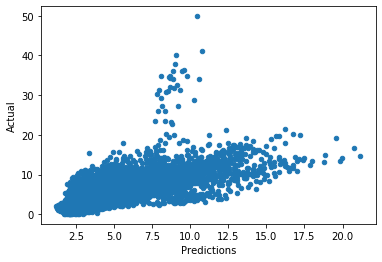

In [358]:
res.plot.scatter("Predictions", "Actual")